In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

In [2]:
def get_nullframe(dataset):
    null_sum = dataset.isnull().sum()[dataset.isnull().sum()>0] 
    return pd.DataFrame({'feature':null_sum.index,'count':null_sum.values,
                          'null_percent':(null_sum.values/dataset.shape[0])*100}).sort_values(by=['count'],ascending=False)

In [3]:
from sklearn import metrics
from sklearn.metrics import roc_curve
def measure_performance(X, y, clf, show_accuracy=True,show_classification_report=True,
                        show_confusion_matrix=True, show_r2_score=False):
    y_pred = clf.predict(X) 
    if show_accuracy:
        print ("Accuracy:{0:.3f}".format( metrics.accuracy_score(y, y_pred)) )
    if show_classification_report:
        print ("Classification report")
        print (metrics.classification_report(y, y_pred))
    if show_confusion_matrix:
        print("Confusion matrix") 
        print(metrics.confusion_matrix(y, y_pred),)
    if show_r2_score:
        print ("Coefficient of determination:{0:.3f}"
               .format( metrics.r2_score(y, y_pred)))
    return y_pred

In [4]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
def plot_learning_curve(train_sizes, train_scores, validation_scores):
    plt.figure()
    plt.title("Learning Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g" ,label="Cross-validation score")
    plt.ylim(max(-3, validation_scores_mean.min() - .1), train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

In [5]:
from sklearn.model_selection import validation_curve
def plot_validation_curve(parameter_values, train_scores, validation_scores):
    plt.figure()
    plt.title("Validation Curve")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.fill_between(parameter_values, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(parameter_values, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    plt.plot(parameter_values, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(parameter_values, validation_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.ylim(validation_scores_mean.min() - .1, train_scores_mean.max() + .1)
    plt.legend(loc="best")
    plt.show()

In [6]:
def plot_roc(X_val,y_val,model):
    fpr, tpr, thresholds = roc_curve(y_val, model.predict_proba(X_val)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")
    plt.title("roc_curve");
    # find threshold closest to zero:
    close_zero = np.argmin(np.abs(thresholds))
    plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
    plt.legend(loc=4)
    plt.show()

In [7]:
def test_classifier(model,X,y,cv):
    clf = model.fit(X,y.values.ravel())
    result = clf.score(X,y.values)
    print ("Accuracy: {0:.3f}".format(result*100.0))

    train_sizes, train_scores, validation_scores = learning_curve(clf, X,y.values.ravel(),cv=cv)
    plot_learning_curve(train_sizes, train_scores, validation_scores)
    return clf,result

In [8]:
train=pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
test=pd.read_csv("test_Y3wMUE5_7gLdaTN.csv")

In [9]:
train_original=train.copy()
test_original=test.copy()

In [10]:
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [11]:
train['Loan_Status'].value_counts(normalize=True)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

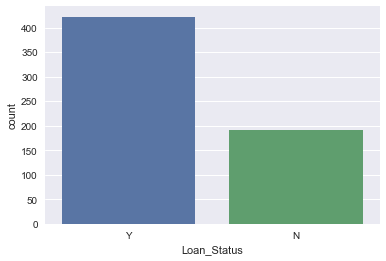

In [12]:
ax = sns.countplot(x="Loan_Status", data=train)

In [13]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [14]:
continuous_ds = train.select_dtypes(np.number)
continuous_columns = continuous_ds.columns.values.tolist()
continuous_columns

['ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History']

In [15]:
categorical_ds = train.select_dtypes("object")
categorical_columns = categorical_ds.columns.values.tolist()
ordinal_columns =['Dependents','Education','Property_Area']
categorical_columns = [ column for column in categorical_columns if column not in ordinal_columns ]
categorical_columns.remove('Loan_ID')

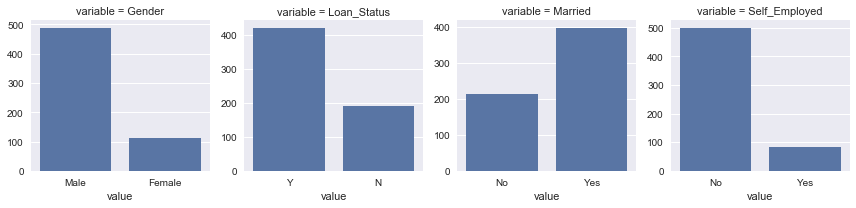

In [16]:
f = pd.melt(train, value_vars=sorted(categorical_columns))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')

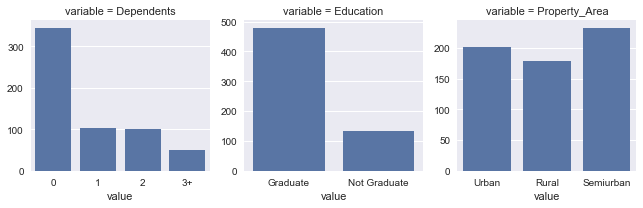

In [17]:
f = pd.melt(train, value_vars=sorted(ordinal_columns))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.countplot, 'value')

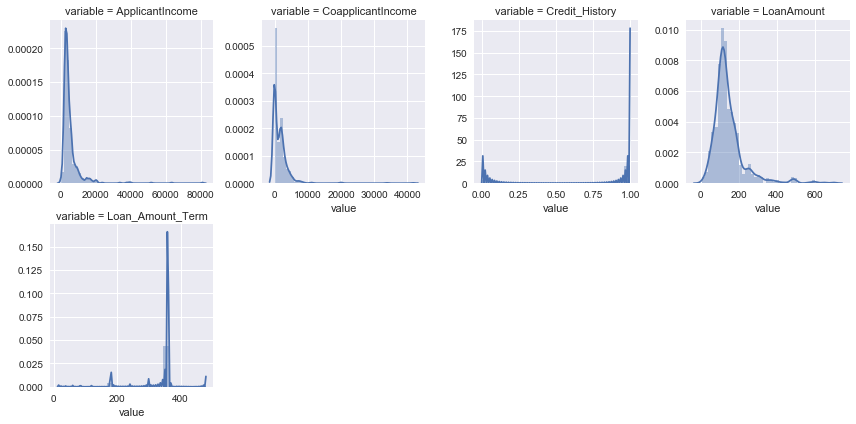

In [18]:
f = pd.melt(train, value_vars=sorted(continuous_ds))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

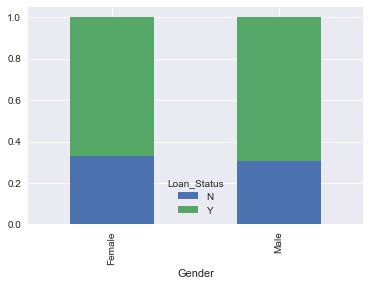

In [19]:
gender=pd.crosstab(train['Gender'],train['Loan_Status'])
gender.div(gender.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

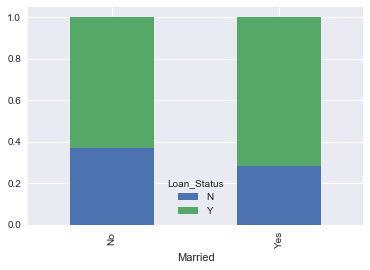

In [20]:
married=pd.crosstab(train['Married'],train['Loan_Status'])
married.div(married.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

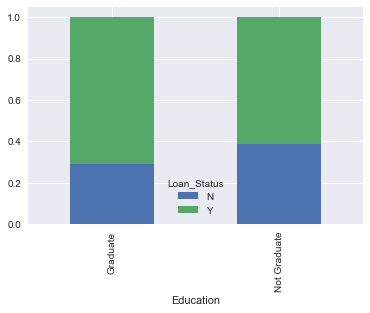

In [21]:
education=pd.crosstab(train['Education'],train['Loan_Status'])
education.div(education.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

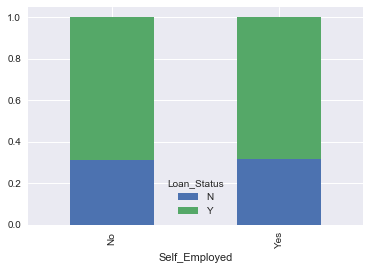

In [22]:
self_employed=pd.crosstab(train['Self_Employed'],train['Loan_Status'])
self_employed.div(self_employed.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

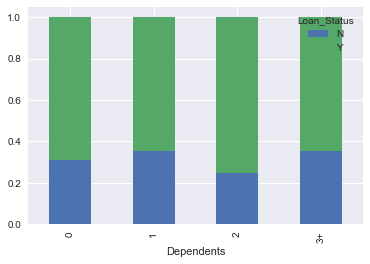

In [23]:
#Credit_History
dependents=pd.crosstab(train['Dependents'],train['Loan_Status'])
dependents.div(dependents.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

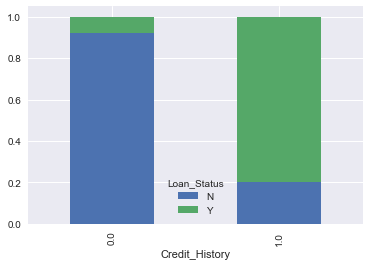

In [24]:
#Credit_History
Credit_History=pd.crosstab(train['Credit_History'],train['Loan_Status'])
Credit_History.div(Credit_History.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6,4))

In [25]:
Credit_History

Loan_Status,N,Y
Credit_History,,
0.0,82,7
1.0,97,378


In [26]:
train[ (train['Credit_History'].notnull()) &(train['Dependents']!='0')]['Credit_History'].value_counts()

1.0    204
0.0     44
Name: Credit_History, dtype: int64

In [27]:
train[ (train['Credit_History']==0) &(train['Dependents']!='0')]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N
23,LP001050,NaN,Yes,2,Not Graduate,No,3365,1917.0,112.0,360.0,0.0,Rural,N
54,LP001186,Female,Yes,1,Graduate,Yes,11500,0.0,286.0,360.0,0.0,Urban,N
63,LP001213,Male,Yes,1,Graduate,No,4945,0.0,NaN,360.0,0.0,Rural,N
73,LP001250,Male,Yes,3+,Not Graduate,No,4755,0.0,95.0,NaN,0.0,Semiurban,N
78,LP001263,Male,Yes,3+,Graduate,No,3167,4000.0,180.0,300.0,0.0,Semiurban,N
108,LP001379,Male,Yes,2,Graduate,No,3800,3600.0,216.0,360.0,0.0,Urban,N
128,LP001451,Male,Yes,1,Graduate,Yes,10513,3850.0,160.0,180.0,0.0,Urban,N
155,LP001536,Male,Yes,3+,Graduate,No,39999,0.0,600.0,180.0,0.0,Semiurban,Y
162,LP001565,Male,Yes,1,Graduate,No,3089,1280.0,121.0,360.0,0.0,Semiurban,N


In [28]:
test[ (test['Credit_History'].notnull()) &(test['Dependents']!='0')]['Credit_History'].value_counts()

1.0    127
0.0     26
Name: Credit_History, dtype: int64

In [29]:
Credit_History_Married=pd.crosstab(train['Credit_History'],train['Married'],train['Loan_Status'],margins=True, aggfunc='count')
Credit_History_Married

Married,No,Yes,All
Credit_History,,,
0.0,32,57,89
1.0,167,305,472
All,199,362,561


In [30]:
train_null =get_nullframe(train)
train_null

,feature,count,null_percent
6,Credit_History,50,8.143322
3,Self_Employed,32,5.211726
4,LoanAmount,22,3.583062
2,Dependents,15,2.442997
5,Loan_Amount_Term,14,2.280130
0,Gender,13,2.117264
1,Married,3,0.488599


In [31]:
test_null =get_nullframe(test)
test_null

,feature,count,null_percent
5,Credit_History,29,7.901907
2,Self_Employed,23,6.267030
0,Gender,11,2.997275
1,Dependents,10,2.724796
4,Loan_Amount_Term,6,1.634877
3,LoanAmount,5,1.362398


In [32]:
train_credit_null_index = train[(train['Married']=='Yes') &
                                (train['CoapplicantIncome']!=0) 
                                &(train['Credit_History'].isnull())].index.tolist()
test_credit_null_index=test[(test['Married']=='Yes') & 
                            (test['CoapplicantIncome']!=0) &
                            (test['Credit_History'].isnull())].index.tolist()

train.loc[train_credit_null_index,'Credit_History']=1
test.loc[test_credit_null_index,'Credit_History']=1

train['Credit_History'].fillna(-1, inplace=True)
test['Credit_History'].fillna(-1, inplace=True)

train['Self_Employed'].fillna(train['Self_Employed'].mode()[0], inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0], inplace=True)

train['Dependents'].fillna(train['Dependents'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)

#train['LoanAmount'].fillna(train['LoanAmount'].median(),inplace=True)
#test['LoanAmount'].fillna(test['LoanAmount'].median(),inplace=True)
#Loan_Amount_Term
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].median(),inplace=True)
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].median(),inplace=True)
train['Gender'].fillna(train['Gender'].mode()[0], inplace=True)
test['Gender'].fillna(test['Gender'].mode()[0], inplace=True)

train_Married_null_index = train[ 
                                (train['CoapplicantIncome']!=0) 
                                &(train['Married'].isnull())].index.tolist()

train.loc[train_Married_null_index,'Married']='Yes'
train['Married'].fillna('No',inplace=True)

In [33]:
train_null =get_nullframe(train)
train_null

,feature,count,null_percent
0,LoanAmount,22,3.583062


In [34]:
test_null =get_nullframe(test)
test_null

,feature,count,null_percent
0,LoanAmount,5,1.362398


In [35]:

def emi_calculator(row): 
    r = 9.5 / (12 * 100) # one month interest 
    return (row['LoanAmount'] * r * pow(1 + r, row['Loan_Amount_Term'])) / (pow(1 + r, row['Loan_Amount_Term']) - 1) 
 

In [36]:
train['Loan_Status'].replace('N', 0,inplace=True)
train['Loan_Status'].replace('Y', 1,inplace=True)
full_dataset =pd.concat(objs=[train, test], axis=0,sort =True).reset_index(drop=True) 
table = full_dataset.pivot_table(values='LoanAmount', index='Self_Employed' ,columns='Education', aggfunc=np.median)
def fage(x):
 return table.loc[x['Self_Employed'],x['Education']]

# Replace missing values
full_dataset['LoanAmount'].fillna(full_dataset[full_dataset['LoanAmount'].isnull()].apply(fage, axis=1), inplace=True)

In [37]:
full_dataset['TotalIncome'] =  full_dataset['ApplicantIncome']+ full_dataset['CoapplicantIncome']
full_dataset['HasCoApplicant'] = full_dataset['CoapplicantIncome'].apply(lambda x: "Y" if x > 0 else "N")
full_dataset['EMI'] = full_dataset.apply(emi_calculator,axis=1)
full_dataset['Balance_Income']= full_dataset['TotalIncome']-(full_dataset['EMI']) 
#full_dataset['DebtIncomeRatio'] = (full_dataset['TotalIncome']/full_dataset['LoanAmount']) 
full_dataset['Loan_Amount_Term']= full_dataset['Loan_Amount_Term']/12
full_dataset['Credit_History']  = full_dataset['Credit_History'].astype(str)
full_dataset.head()


,ApplicantIncome,CoapplicantIncome,Credit_History,Dependents,Education,Gender,LoanAmount,Loan_Amount_Term,Loan_ID,Loan_Status,Married,Property_Area,Self_Employed,TotalIncome,HasCoApplicant,EMI,Balance_Income
0,5849,0.0,1.0,0,Graduate,Male,130.0,30.0,LP001002,1.0,No,Urban,No,5849.0,N,1.093110,5847.906890
1,4583,1508.0,1.0,1,Graduate,Male,128.0,30.0,LP001003,0.0,Yes,Rural,No,6091.0,Y,1.076293,6089.923707
2,3000,0.0,1.0,0,Graduate,Male,66.0,30.0,LP001005,1.0,Yes,Urban,Yes,3000.0,N,0.554964,2999.445036
3,2583,2358.0,1.0,0,Not Graduate,Male,120.0,30.0,LP001006,1.0,Yes,Urban,No,4941.0,Y,1.009025,4939.990975
4,6000,0.0,1.0,0,Graduate,Male,141.0,30.0,LP001008,1.0,No,Urban,No,6000.0,N,1.185604,5998.814396


In [38]:
#pd.cut(full_dataset['Loan_Amount_Term'],bins =4).unique()
#full_dataset['Loan_Amount_Term_Band'] = pd.cut(full_dataset['Loan_Amount_Term'], 3)
#full_dataset.loc[ (full_dataset['Loan_Amount_Term'] > 0.46 ) & (full_dataset['Loan_Amount_Term'] <= 13.667), 'Loan_Amount_Term'] = 0
#full_dataset.loc[(full_dataset['Loan_Amount_Term'] > 13.667) & (full_dataset['Loan_Amount_Term'] <=26.833), 'Loan_Amount_Term'] = 1
#full_dataset.loc[(full_dataset['Loan_Amount_Term'] > 26.833) & (full_dataset['Loan_Amount_Term'] <= 40.0), 'Loan_Amount_Term'] = 2


In [39]:
#full_dataset['Very_Short_Term'] = full_dataset['Loan_Amount_Term'].map(lambda t: 1 if t<=60 else 0)
#full_dataset['Short_Term'] = full_dataset['Loan_Amount_Term'].map(lambda t: 1 if t>60 and t<180 else 0)
#full_dataset['Long_Term'] = full_dataset['Loan_Amount_Term'].map(lambda t: 1 if t>=180 and t<=300  else 0)
#full_dataset['Very_Long_Term'] = full_dataset['Loan_Amount_Term'].map(lambda t: 1 if t>300 else 0)
#full_dataset.drop('Loan_Amount_Term', axis=1, inplace=True)

In [40]:
null_dataset =get_nullframe(full_dataset)
null_dataset

,feature,count,null_percent
0,Loan_Status,367,37.410805


In [41]:
cat_list = [column for column in  full_dataset.columns if column not in full_dataset.describe(include=[np.number]).columns.values.tolist()]
cat_list.remove('Loan_ID') 

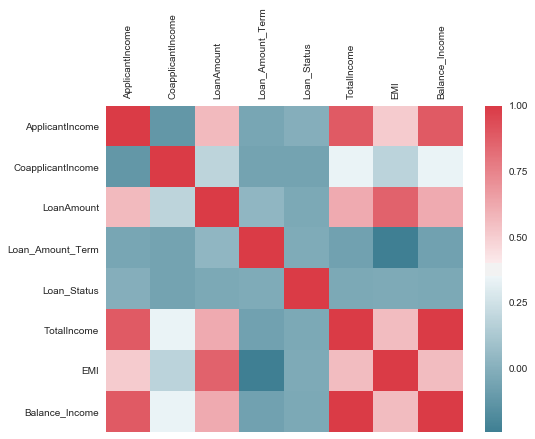

In [42]:
correlation = full_dataset[full_dataset['Loan_Status'].notnull()][full_dataset.describe(include=[np.number]).columns.values.tolist()].corr()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, 
           xticklabels=correlation.columns.values,
           yticklabels=correlation.index.values,
           cmap=cmap)
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

#correlation = correlation.sort_values('Loan_Status', ascending=False)
#plt.figure(figsize=(8,10))
#sns.barplot( correlation['Loan_Status'][1:], correlation.index[1:], orient='h')
#plt.show()

In [43]:
train_Id  = full_dataset[full_dataset['Loan_Status'].notnull()]["Loan_ID"]
test_Id = full_dataset[full_dataset['Loan_Status'].isnull()]["Loan_ID"]
full_dataset.drop(['Loan_ID','ApplicantIncome','CoapplicantIncome'],axis=1,inplace=True)

In [44]:
full_dataset = pd.get_dummies(full_dataset, prefix_sep='_', drop_first=False)

In [45]:
heatmap_data =full_dataset[full_dataset['Loan_Status'].notnull()]
corr_matrix =heatmap_data.corr('pearson')
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 
correlation_threshold = 0.80
to_drop = [column for column in upper.columns if any(upper[column].abs() > correlation_threshold) and column not in ['Loan_Status',]]
to_drop   

correlated_predictors ={}
record_collinear = pd.DataFrame(columns = ['drop_feature', 'corr_feature', 'corr_value'])
for column in to_drop:
    co_related_features = list(upper.index[upper[column].abs() > correlation_threshold])
    co_related_values = list(upper[column][upper[column].abs() > correlation_threshold])
    drop_features = [column for _ in range(len(co_related_features))]  

    temp_df = pd.DataFrame.from_dict({'drop_feature': drop_features,
                                             'corr_feature': co_related_features,
                                             'corr_value': co_related_values})
    record_collinear = record_collinear.append(temp_df, ignore_index = True)
record_collinear.sort_values(by=['corr_value'],ascending=True)

,drop_feature,corr_feature,corr_value
3,Education_Not Graduate,Education_Graduate,-1.000000
4,Gender_Male,Gender_Female,-1.000000
5,Married_Yes,Married_No,-1.000000
6,Self_Employed_Yes,Self_Employed_No,-1.000000
7,HasCoApplicant_Y,HasCoApplicant_N,-1.000000
2,Credit_History_1.0,Credit_History_0.0,-0.862279
0,EMI,LoanAmount,0.862223
1,Balance_Income,TotalIncome,1.000000


In [46]:
#full_dataset.drop(['Education_Not Graduate','Gender_Male','Married_Yes','Self_Employed_Yes','HasCoApplicant_Y',
#                   'Credit_History_1.0','Balance_Income'],
#                  axis=1,inplace=True)

In [47]:
num_list=['LoanAmount', 'TotalIncome', 'EMI', ]

In [48]:
from datatools.customtransformers import StdScaleTransformer,RobustScaleTransformer,MinMaxTransformer
rbst_scaler = MinMaxTransformer(num_list)
full_dataset =rbst_scaler.fit_transform(full_dataset)

In [49]:
Checkpoint

NameError: name 'Checkpoint' is not defined

In [50]:
train_X = full_dataset[full_dataset['Loan_Status'].notnull()] 
test_X = full_dataset[full_dataset['Loan_Status'].isnull()]  
train_y= full_dataset[full_dataset['Loan_Status'].notnull()]['Loan_Status']
train_X.drop(['Loan_Status'],axis=1,inplace=True)
test_X.drop(['Loan_Status'],axis=1,inplace=True)

In [51]:
from sklearn.model_selection import train_test_split
print(train_X.shape)
print(test_X.shape)
test_size = 0.25
seed = 42
X_trainmodel, X_val, y_trainmodel, y_val = train_test_split(train_X, train_y, test_size=test_size,random_state=seed)

(614, 25)
(367, 25)


In [52]:
X_trainmodel.head()

,LoanAmount,Loan_Amount_Term,TotalIncome,EMI,Balance_Income,Credit_History_-1.0,Credit_History_0.0,Credit_History_1.0,Dependents_0,Dependents_1,...,Gender_Male,Married_No,Married_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Self_Employed_No,Self_Employed_Yes,HasCoApplicant_N,HasCoApplicant_Y
92,0.104197,30.0,0.045891,0.026644,5092.318908,0,0,1,0,0,...,1,0,1,0,0,1,1,0,0,1
304,0.189580,30.0,0.063576,0.048478,6498.822804,0,0,1,1,0,...,1,1,0,1,0,0,1,0,0,1
68,0.167873,5.0,0.071118,0.112206,7097.374767,0,0,1,0,0,...,1,0,1,0,0,1,0,1,1,0
15,0.167873,30.0,0.044094,0.042927,4948.948932,0,0,1,1,0,...,1,1,0,0,0,1,1,0,1,0
211,0.172214,30.0,0.040700,0.044037,4678.923707,0,1,0,0,0,...,1,0,1,0,1,0,1,0,0,1


In [53]:
from sklearn.linear_model import LogisticRegression
logrmodel = LogisticRegression()
logrmodel.fit(X_trainmodel, y_trainmodel.values.ravel())
result = logrmodel.score(X_val, y_val)
print ("Accuracy: {0:.3f}".format(result*100.0))

Accuracy: 77.273


Accuracy: 81.739


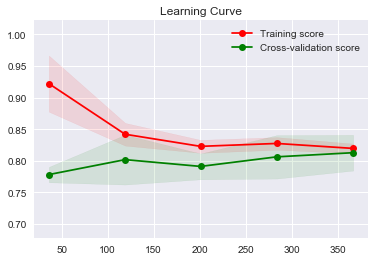

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


In [54]:
kfold = StratifiedKFold(n_splits=5)
logrmodel ,result = test_classifier(logrmodel,X_trainmodel,y_trainmodel,kfold)
print(logrmodel)

In [55]:
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter space
C = np.logspace(0, 6, 10)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logrmodel, hyperparameters, cv=5, verbose=0,scoring='accuracy')
best_model = clf.fit(X_trainmodel, y_trainmodel.values.ravel())
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 1.0


Accuracy: 81.957


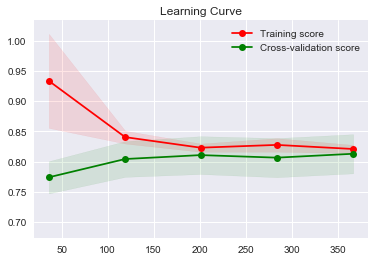

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e+00, 4.64159e+00, 2.15443e+01, 1.00000e+02, 4.64159e+02,
       2.15443e+03, 1.00000e+04, 4.64159e+04, 2.15443e+05, 1.00000e+06]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)


In [56]:
best_lr_model ,result = test_classifier(best_model,X_trainmodel,y_trainmodel,kfold)
print(best_lr_model)

In [57]:
y_pred=measure_performance(X_val,y_val,best_lr_model, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

Classification report
             precision    recall  f1-score   support

        0.0       0.91      0.39      0.55        54
        1.0       0.75      0.98      0.85       100

avg / total       0.81      0.77      0.74       154

Confusion matrix
[[21 33]
 [ 2 98]]


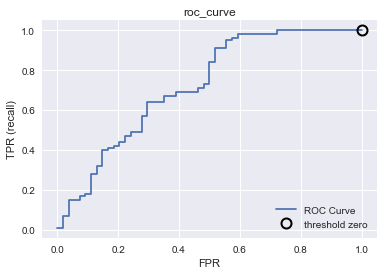

In [58]:
plot_roc(X_val,y_val,best_lr_model)

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
## Search grid for optimal parameters
parameter_grid = {
                 'max_depth' : [3,5],
                 'n_estimators': [200],
                 'max_features': ['sqrt'],
                 'min_samples_split': [3,5,8],
                 'min_samples_leaf': [3,7,10]
                  #"oob_score":[True]
                  #"class_weight":[{0: 0.61616, 1: 0.38384}]
                 }

rfcg =RandomForestClassifier()
grid_search = GridSearchCV(rfcg,param_grid = parameter_grid,verbose = 1,n_jobs =-1,cv=kfold,scoring='accuracy')
grid_search.fit(X_trainmodel ,y_trainmodel.values.ravel())

rfc_best = grid_search.best_estimator_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   30.6s finished


In [1]:
best_model ,result = test_classifier(rfc_best,X_trainmodel,y_trainmodel,kfold)
print(best_model)

NameError: name 'test_classifier' is not defined

In [ ]:
plot_roc(X_val,y_val,best_model)

In [ ]:
y_pred=measure_performance(X_val,y_val,best_model, show_accuracy=False, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

In [ ]:
test_y = best_model.predict(test_X)
submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 
submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)
import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="submission_rf"+timestamp+"_out.csv"

In [ ]:
submission.to_csv(filename)

In [ ]:
features = pd.DataFrame()
features['feature'] = X_trainmodel.columns
features['importance'] = best_model.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh', figsize=(4, 10))

In [ ]:
from sklearn.feature_selection import SelectFromModel
model = SelectFromModel(best_model, prefit=True)
train_reduced = model.transform(X_trainmodel)
train_validation =model.transform(X_val)
test_reduced =model.transform(test_X)

train_reduced.shape

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
train_reduced =poly.fit_transform(train_reduced)
train_validation = poly.transform(train_validation)
test_reduced =poly.transform(test_reduced)


In [ ]:
test_reduced.shape

In [ ]:
parameter_grid = {
                 'max_depth' : [3,5],
                 'n_estimators': [100],
                 'max_features': [5],
                 'min_samples_split': [3,5,8],
                 'min_samples_leaf': [3,5,]
                  #"oob_score":[True]
                  #"class_weight":[{0: 0.61616, 1: 0.38384}]
                 }

rfcg =RandomForestClassifier()
grid_search = GridSearchCV(rfcg,param_grid = parameter_grid,verbose = 1,n_jobs =-1,cv=kfold,scoring='accuracy')
grid_search.fit(train_reduced ,y_trainmodel.values.ravel())

rfc_best = grid_search.best_estimator_

In [ ]:
best_model ,result = test_classifier(rfc_best,train_reduced,y_trainmodel,kfold)
print(best_model)

In [ ]:
plot_roc(train_validation,y_val,best_model)

In [ ]:
y_pred=measure_performance(train_validation,y_val,best_model, show_accuracy=True, 
                    show_classification_report=True,
                    show_confusion_matrix=True, show_r2_score=False)

In [ ]:
test_y = best_model.predict(test_reduced)

submission =pd.DataFrame({'Loan_ID':test_Id.values ,'Loan_Status':test_y}) 

submission['Loan_Status'].replace(0, 'N',inplace=True)
submission['Loan_Status'].replace(1, 'Y',inplace=True)

import datetime
FORMAT = '%Y%m%d%H%M%S'
timestamp=datetime.datetime.now().strftime(FORMAT)
filename ="submission_rf_reduced"+timestamp+"_out.csv"

In [ ]:
submission.to_csv(filename)